In [2]:
import scipy.io as scio
import os
import numpy as np
import sklearn.metrics as metrics
from sklearn import svm
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd
from sklearn.metrics import f1_score,recall_score,precision_score,auc,accuracy_score,confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from scipy import interp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D,Conv1D,Conv1DTranspose
from tensorflow.keras.layers import MaxPooling1D, Dropout, UpSampling1D,MaxPool2D,UpSampling2D
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import notebook
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [6]:
path='./CWRU/'
#寻找文件夹下所有的数据文件
path_list=os.listdir(path)
data_x=[]
data_y=[]
for i in path_list:
    path1=path+i
    dd=scio.loadmat(path1)
    for j in dd.keys():
        #只使用DE的数据
        if 'DE' in j:
            ddd=dd[j]
            #截前12W个数据
            data_x.append(ddd[:120000].ravel())
            data_y.append(i)

In [7]:
#切分成多个样本数据
def yuchuli(a,label):
    """
    前200个样本用于训练
    后100个样本用于测试
    """
    a  = a.reshape(300,400)
    np.random.shuffle(a)
    train = a[:200,:]
    test = a[200:,:]
    label_test =[label for i in range(0,100)]
    label_train = [label for i in range(0, 200)]
    return train,test,label_train ,label_test



#绘制P-R曲线
def micro_PR(y_test,y_score):
    # 对每一个类别计算性能指标
    precision = dict()
    recall = dict()
    average_precision = dict()
    # .shape会返回一个元组，存储行和列，取第二个数，也就是列
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        precision[i], recall[i], _ =  precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"],  recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
    return precision, recall, average_precision

def plot_a_model_PR_curve(precision,recall,average_precision,title=None,path=None):
    plt.figure(figsize=(6,6))
    for i in precision.keys():
        label = str(i)+"，AP = {0:0.4f}".format(average_precision[i])
        plt.step(recall[i], precision[i], where='post', lw=2,label=label)
    plt.legend()
    plt.xlabel("Recall", fontdict={'weight': 'normal', 'size': 15})
    plt.ylabel("Precision", fontdict={'weight': 'normal', 'size': 15})
    if title != None:
        plt.title(title)
        
    if path!= None:
        plt.savefig(path,dpi=700)
    plt.show()

    
#将y转变为onehot向量
def to_one_hot(labels,label_dict):
    dimension=len(label_dict.keys())
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label_dict[label]] = 1
    return results

In [8]:
#将多条数据的所有样本合并起来
x_train,x_test,y_train,y_test=[],[],[],[]
for i in range(len(data_x)):
    train,test,label_train ,label_test=yuchuli(data_x[i],data_y[i])
    x_train+=list(train)
    x_test+=list(test)
    y_train+=label_train
    y_test+=label_test
    
#转换数据格式
x_train=np.array(x_train)
x_test=np.array(x_test)

#将x转变为二维矩阵，方便CNN训练
x_train = x_train.reshape(-1,400,1)
x_test = x_test.reshape(-1,400,1)

state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)

#转换y的数据格式
y_train=np.array(y_train)
y_test=np.array(y_test)

#生成label的字典，用于将y转换为onehot格式
label_dict={}
label_dict_anti={}
for i,j in enumerate(list(set(list(y_train)+list(y_test)))):
    label_dict[j]=i
    label_dict_anti[i]=j
    

one_hot_train_labels = to_one_hot(y_train,label_dict)
one_hot_test_labels = to_one_hot(y_test,label_dict)

y_test_transform=np.argmax(one_hot_test_labels,axis=1)
y_train_transform=np.argmax(one_hot_train_labels,axis=1)

input_shape=x_train.shape[1:]
output=one_hot_train_labels.shape[1]

In [9]:
one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
x_train.shape,x_test.shape

((2000, 400, 1), (1000, 400, 1))

In [8]:
y_train_transform.shape,y_test_transform.shape

((2000,), (1000,))

Model

In [9]:
num_classes = len(np.unique(y_train_transform))
num_classes

10

In [10]:
input_img = Input(shape=(400,1)) # Tensorflow后端， 注意要用channel_last
# 编码器部分
x = Conv1D(32, 10, activation='relu', padding='same',strides=2)(input_img)
x = tf.keras.layers.BatchNormalization()(x)
x = Conv1D(30, 10, activation='relu', padding='same',strides=2)(x)
x = Conv1D(30, 10, activation='relu', padding='same',strides=2)(x)
x=Flatten()(x)
decoded=Dense(10,activation='softmax')(x)
                 

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])   
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 32)           352       
                                                                 
 batch_normalization (BatchN  (None, 200, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 30)           9630      
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 30)            9030      
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                             

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
history = autoencoder.fit(x_train, 
                            y_train_transform,
                          epochs=100,
                          batch_size=16,
                        #   shuffle=True,
                          validation_split=0.2,
                          verbose=1, 
                          callbacks=callbacks).history

Epoch 1/100
100/100 [==============================] - 4s 5ms/step - loss: 1.5312 - sparse_categorical_accuracy: 0.4112 - val_loss: 1.8506 - val_sparse_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.4774 - sparse_categorical_accuracy: 0.8344 - val_loss: 1.2824 - val_sparse_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.7521 - val_sparse_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.3564 - val_sparse_categorical_accuracy: 0.8950 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9600 - lr: 0.0010
Epoch 6/100
100/100 [=========

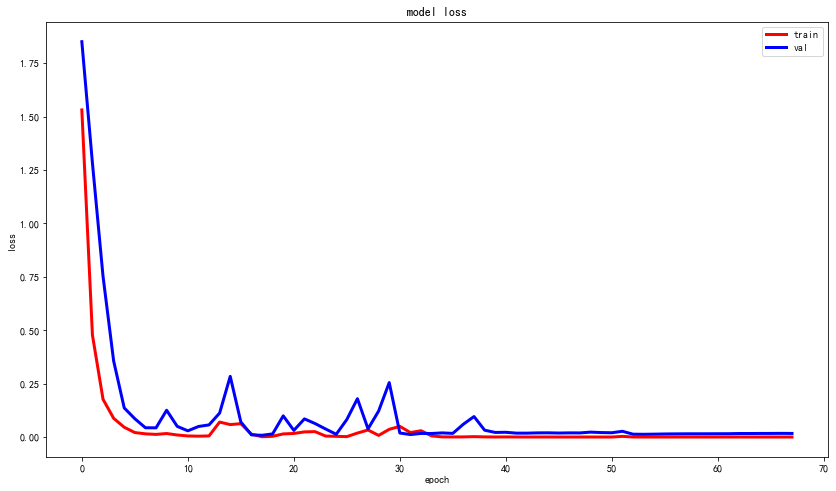

In [12]:
import seaborn as sns
# # plt.figure(figsize=(14, 5))
# plt.subplot(121)
plt.figure(figsize=(14,8))
# # sns.set(font_scale = 0.5)
plt.plot(history['loss'][:], c='red', lw=3)
plt.plot(history['val_loss'][:], c='blue', lw=3)
plt.title('model loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

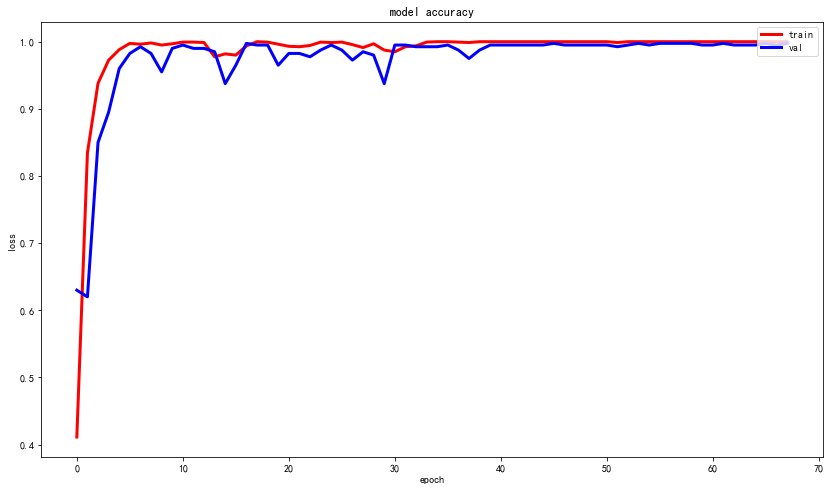

In [13]:
import seaborn as sns
# # plt.figure(figsize=(14, 5))
# plt.subplot(121)
plt.figure(figsize=(14,8))
# # sns.set(font_scale = 0.5)
plt.plot(history['sparse_categorical_accuracy'][:], c='red', lw=3)
plt.plot(history['val_sparse_categorical_accuracy'][:], c='blue', lw=3)
plt.title('model accuracy')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [14]:
pred_test = autoencoder.predict(x_test)

In [15]:
pred_test.shape

(1000, 10)

In [16]:
#返回数组中最大的索引值，二维：0--外层 1--内层
pre=np.argmax(pred_test,axis=1)

In [17]:
test_y=np.argmax(one_hot_test_labels,axis=1)

In [18]:
correct_prediction = tf.equal(pre, test_y)
acc = tf.reduce_mean(tf.cast(correct_prediction, "float"))
acc=float(acc)
# f1=metrics.f1_

In [19]:
acc

0.9879999756813049